In [1]:
%matplotlib inline

Using TensorFlow backend.



 ---- Test Params ----
{'activation': 'relu', 'batch_size': 36, 'epochs': 36, 'loss': <function mean_absolute_error at 0x7fd4f1184f28>, 'neurons': 36, 'optimizer_lr': 0.01}


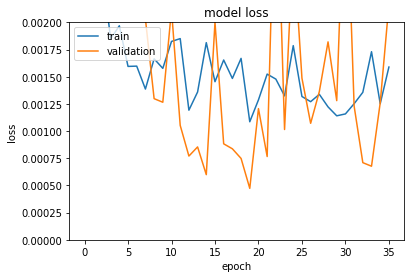


Test RMSE: 17.330

 ---- Test Params ----
{'activation': 'relu', 'batch_size': 36, 'epochs': 36, 'loss': <function mean_absolute_error at 0x7fd4f1184f28>, 'neurons': 36, 'optimizer_lr': 0.01}


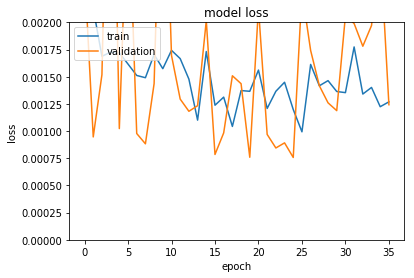


Test RMSE: 27.306

 ---- Test Params ----
{'activation': 'relu', 'batch_size': 36, 'epochs': 36, 'loss': <function mean_absolute_error at 0x7fd4f1184f28>, 'neurons': 36, 'optimizer_lr': 0.01}


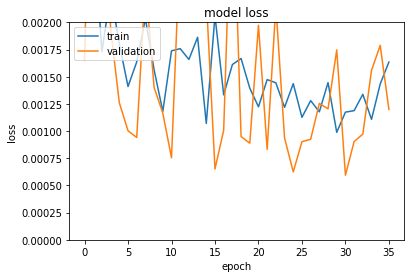


Test RMSE: 20.716

 ---- Test Params ----
{'activation': 'relu', 'batch_size': 36, 'epochs': 36, 'loss': <function mean_absolute_error at 0x7fd4f1184f28>, 'neurons': 36, 'optimizer_lr': 0.01}


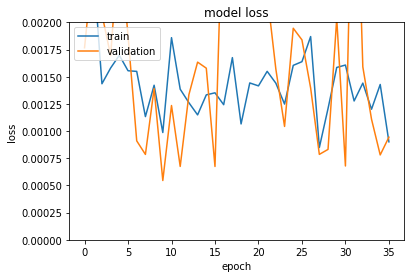


Test RMSE: 25.596

 ---- Test Params ----
{'activation': 'relu', 'batch_size': 36, 'epochs': 36, 'loss': <function mean_absolute_error at 0x7fd4f1184f28>, 'neurons': 36, 'optimizer_lr': 0.01}


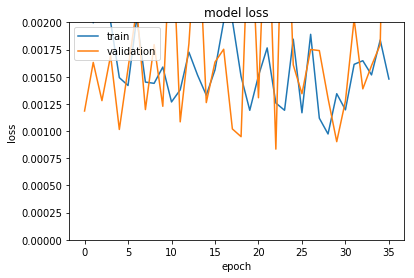


Test RMSE: 37.572
----- best model error ------
{'activation': 0, 'batch_size': 0, 'epochs': 0, 'loss': 0, 'lr': 0, 'neurons': 0}


In [2]:
import os
import sys
import time
import json
import re
import numpy
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Merge, Input, concatenate
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses
from keras import backend as K
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

#import seaborn as sns
#sns.despine()

def write_dict_to_csv( list_datas, list_header, output_file_path ):
    
    # https://stackoverflow.com/questions/12517451/automatically-creating-directories-with-file-output
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
        
    with open(output_file_path, 'w') as f:
        f.write( ','.join(list_header)  + '\n')
              
        for this_data in list_datas:
            run_flag = 0
            output_string = ''
                
            for this_key in list_header:
                run_flag = run_flag + 1
                if run_flag == 1:
                    output_string = str(this_data[this_key])
                else:
                    output_string = output_string + ',' + str(this_data[this_key])
        
            f.write(output_string + '\n')

            
def prepare_data():
    # load dataset
    input_file_path = './outputs_manual_train/stats/profile_qty_price_multiple_day/profile_qty_price_multiple_day_for_machine_learning.csv'
    dataset = read_csv(input_file_path, header=0, index_col=0, \
                       dtype={'symbol': str, \
                              'price_1': float, \
                              'qty_ratio_1': float, \
                              'price_2': float, \
                              'qty_ratio_2': float, \
                              'price_3': float, \
                              'qty_ratio_3': float, \
                              'qty_total': float, \
                              'price_item_count': float, \
                              'future_buy_price': float, \
                              'future_sell_price': float
                             })

    #https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe-using-del-df-column-name
    dataset = dataset.drop('symbol', 1)
    #dataset = dataset.drop('future_sell_price', 1)
    #display(dataset)

    # shuffle input data
    #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    dataset = dataset.sample(frac=1)
    #display(dataset)

    #values = dataset.values
    #print(values)
    #print('\n\n')

    # auto-label your data to 0,1,2... example 'a', 'a', 'b', 'c'  --> 0 0 1 2
    #encoder = LabelEncoder()
    #values[:,0] = encoder.fit_transform(values[:,0])
    #print(values)
    #print('\n\n')

    # ensure all data is float
    #values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_dataset = scaler.fit_transform(dataset)
    scaled_df = DataFrame(scaled_dataset)
    #display(scaled_df)
    #print('\n\n')

    #sys.exit()

    # specify the number of lag hours
    #n_hours = 3
    #n_features = 8
    # frame as supervised learning
    # reframed = series_to_supervised(scaled, n_hours, 1)
    reframed = scaled_df

    # .shape will return (rows, cols)
    #print('\n------ reframed.shape -------')
    #print(reframed.shape)
    #print(reframed.shape[0])


    # split into train and test sets
    values = reframed.values
    n_rows_split_for_train_test = round(reframed.shape[0] / 2)
    train = values[:n_rows_split_for_train_test, :]
    test = values[n_rows_split_for_train_test:, :]
    #print('\n------ train data -------')
    #print(train)
    #print('\n------ test data -------')
    #print(test)

    # split into input and outputs
    n_cols_outputs = 1
    n_cols_inputs = reframed.shape[1] - n_cols_outputs

    train_X, train_y = train[:, :n_cols_inputs], train[:, -n_cols_outputs]
    #print('\n------ train_y, train_y data -------')
    #print(train_X.shape, len(train_X), train_y.shape)
    #print('\n------ train_X data -------')
    #print(train_X)
    #print('\n------ train_y data -------')
    #print(train_y)

    test_X, test_y = test[:, :n_cols_inputs], test[:, -n_cols_outputs]


    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print('\n------ reshape input to be 3D [samples, timesteps, features] -------')
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return scaler, train_X, train_y, test_X, test_y

def lstm_experiment(params):
    print('\n ---- Test Params ----')
    print(params)
    
    # get data
    scaler, train_X, train_y, test_X, test_y = prepare_data()
    
    try:
        # design network
        model = Sequential()
        model.add(LSTM(params['neurons'], activation=params['activation'], input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        this_optimizer = Adam(lr=params['optimizer_lr'])
        this_loss = params['loss']
        
        # metrics=['accuracy'] is used for classification problem , metrics=['mean_squared_error'] should be for regression problem
        model.compile(loss=this_loss, optimizer=this_optimizer)
        # fit network
        # verbose: print runtime information
        history = model.fit(train_X, train_y, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(test_X, test_y), verbose=0, shuffle=False)
    except:
        print(' ----- Error!! Something happened -----')
        print(params)
        return {'loss': 999999, 'status': STATUS_OK}
    
    #  "Accuracy"
    #pyplot.plot(history.history['mean_squared_error'], label='train')
    #pyplot.plot(history.history['val_mean_squared_error'], label='test')
    #pyplot.title('model accuracy')
    #pyplot.ylabel('accuracy')
    #pyplot.xlabel('epoch')
    #pyplot.legend(['train', 'validation'], loc='upper right')
    # "Loss"
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    axes = pyplot.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([0,0.002])
    pyplot.show()
    
    # plot history
    #pyplot.plot(history.history['loss'], label='train')
    #pyplot.plot(history.history['val_loss'], label='test')
    #axes = pyplot.gca()
    #axes.set_xlim([xmin,xmax])
    #axes.set_ylim([0,0.002])
    #pyplot.legend()
    #pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    #print(test_X.shape)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    #print(test_X.shape)
    inv_yhat = numpy.concatenate((yhat, test_X[:, :]), axis=1)
    #print(inv_yhat.shape)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = numpy.concatenate((test_y, test_X[:, :]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('\nTest RMSE: %.3f' % rmse)
    #print('\n\n')

    # print test data and predicted data
    #sum_ratio = 0
    #for i in range(len(inv_yhat)):
    #    #print(str(inv_y[i]) + '  ' + str(inv_yhat[i]))
    #    earn_ratio = ( inv_y[i] - inv_yhat[i] ) / inv_yhat[i]
    #    #print(earn_ratio)
    #    sum_ratio = sum_ratio + earn_ratio
    #print('\nTest sum_ratio: %.3f' % sum_ratio)
    #print('\n\n')
    this_result = {}
    this_result['model'] = 'LSTM'
    this_result['neurons'] = params['neurons']
    this_result['activation'] = params['activation']
    this_result['optimizer_lr'] = params['optimizer_lr']
    
    #print(str(params['loss']))
    searchObj = re.search( r'<function (.*) .*', str(params['loss']))
    this_result['loss'] = searchObj.group(1)
    
    this_result['epochs'] = params['epochs']
    this_result['batch_size'] = params['batch_size']
    this_result['RMSE'] = '%.3f' % rmse
    list_params_and_result.append(this_result)
    
    # this line must exist for hyperopt fmin
    return {'loss': rmse, 'status': STATUS_OK}

def lstm_run_all():
    # get data
    scaler, train_X, train_y, test_X, test_y = prepare_data()
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    #optimizer = Adam(lr=params['optimizer_lr'])
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    axes = pyplot.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([0,0.002])
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    #print(test_X.shape)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    #print(test_X.shape)
    inv_yhat = numpy.concatenate((yhat, test_X[:, :]), axis=1)
    #print(inv_yhat.shape)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = numpy.concatenate((test_y, test_X[:, :]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('\nTest RMSE: %.3f' % rmse)
    print('\n\n')

    # print test data and predicted data
    #sum_ratio = 0
    #for i in range(len(inv_yhat)):
    #    #print(str(inv_y[i]) + '  ' + str(inv_yhat[i]))
    #    earn_ratio = ( inv_y[i] - inv_yhat[i] ) / inv_yhat[i]
    #    #print(earn_ratio)
    #    sum_ratio = sum_ratio + earn_ratio
    #print('\nTest sum_ratio: %.3f' % sum_ratio)
    #print('\n\n')
    
if __name__ == '__main__':
    #lstm_run_all()
    #sys.exit()
    list_params_and_result = []
    
    # remove {loss: mean_absolute_percentage_error} for bad RMSE
    space = {   
                'neurons': hp.choice('neurons', [36, 72, 144]),
                'epochs': hp.choice('epochs', [36, 72, 144]),
                'batch_size': hp.choice('batch_size', [36, 72, 144]),
                'optimizer_lr': hp.choice('lr', [0.01, 0.001, 0.0001]),
                'loss': hp.choice('loss', [losses.logcosh,
                                           losses.mse,
                                           losses.mae]),
                'activation': hp.choice('activation',['relu',
                                                      'sigmoid',
                                                      'tanh'
                                                     ])
            }
    # DEBUG use
    space = {   
            'neurons': hp.choice('neurons', [36]),
            'epochs': hp.choice('epochs', [36]),
            'batch_size': hp.choice('batch_size', [36]),
            'optimizer_lr': hp.choice('lr', [0.01]),
            'loss': hp.choice('loss', [losses.mae]),
            'activation': hp.choice('activation',['relu'])
        }


    trials = Trials()
    best = fmin(lstm_experiment, space, algo=tpe.suggest, max_evals=5, trials=trials)    
    
    output_file_path = './outputs_manual_train/stats/lstm_experiment.csv'
    list_header = ['model', 'neurons', 'activation', 'optimizer_lr', 'loss', 'epochs', 'batch_size', 'RMSE']
    write_dict_to_csv( list_params_and_result, list_header, output_file_path )  
    
    print('----- best model error ------')
    print(best)
